In [49]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import re
import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
if src_dir not in sys.path:
    sys.path.append(src_dir)
    
from src.constant import sidewalks, stations

In [54]:

def process_df(base_name):
    input = pd.read_csv(f"../data/PredictionModelOutput/{base_name}_ModelInputs.csv")
    output = pd.read_csv(f"../data/PredictionModelOutput/{base_name}_ModelOutputs.csv")
    features = pd.read_csv(f"../data/FeatureGeneratorOutput/{base_name}.csv")

    input.columns = [c.strip().replace(' ', '_') for c in input.columns]
    output.columns = [c.strip().replace(' ', '_') for c in output.columns]
    features.columns = [c.strip().replace(' ', '_') for c in features.columns]

    input = input[['Timestamp', 'User_X', 'User_Y', 'AGV_X', 'AGV_Y']]

    output = output.groupby('ModelRunTimestamp').apply(lambda x : x[['X', 'Y']].to_numpy()).reset_index()
    output.columns = ['Timestamp', 'pred_traj']

    features = features[['Timestamp', 'Phase1_scenario_num', 'Phase2_scenario_num', 'GazeDirection_X', 'GazeDirection_Y']]
    features[['Phase1_scenario_num', 'Phase2_scenario_num']] = features[['Phase1_scenario_num', 'Phase2_scenario_num']].astype(int)

    # Parameters
    PAST_WINDOW = 30  # how many previous rows (including current) to use
    FUTURE_WINDOW = 40  # how many future rows (including current) to use

    def get_input_traj(dframe, idx, window=30):
        """
        Returns the past `window` rows of [User_X, User_Y], up to and including row `idx`.
        If there aren't enough past rows, you'll get as many as possible from the start.
        """
        start_idx = max(0, idx - (window - 1))
        return dframe.loc[start_idx : idx, ['User_X', 'User_Y']].to_numpy()

    def get_gt_traj(dframe, idx, window=40):
        """
        Returns the future `window` rows of [User_X, User_Y], starting at row `idx`.
        If there aren't enough future rows, you'll get as many as possible until the end.
        """
        end_idx = min(len(dframe) - 1, idx + (window - 1))
        return dframe.loc[idx : end_idx, ['User_X', 'User_Y']].to_numpy()

    input['input_traj'] = input.apply(lambda row: get_input_traj(input, row.name, PAST_WINDOW), axis=1)
    input['gt_traj'] = input.apply(lambda row: get_gt_traj(input, row.name, FUTURE_WINDOW), axis=1)

    # Merge input and output
    data = pd.merge(input, output, on='Timestamp', how='inner')
    data = pd.merge(data, features, on='Timestamp', how='inner')

    data.sort_values(by='Timestamp', inplace=True)
    data = data[['gt_traj', 'pred_traj', 'Phase1_scenario_num', 'Phase2_scenario_num']]

    # data cleaning for pred traj
    error_pred_num = data['pred_traj'].apply(lambda x: x.shape[0] != 40).sum()
    error_gt_num = data['gt_traj'].apply(lambda x: x.shape[0] != 40).sum()
    len_data = len(data)
    data = data[data['gt_traj'].apply(lambda x: x.shape[0] == 40)]
    data = data[data['pred_traj'].apply(lambda x: x.shape[0] == 40)]
    
    if len(data) == 0:
        print(f"Error in {base_name}")
        print(f"Number of rows with incorrect pred_traj: {error_pred_num}, in percentage: {error_pred_num / len_data * 100}%")
        print(f"Number of rows with incorrect gt_traj: {error_gt_num}, in percentage: {error_gt_num / len_data * 100}%")
        return pd.DataFrame()

    data['F1_max'] = data.apply(lambda row: np.max(np.linalg.norm(row['gt_traj'] - row['pred_traj'], axis=1)), axis=1)/100
    data['F1_mean'] = data.apply(lambda row: np.mean(np.linalg.norm(row['gt_traj'] - row['pred_traj'], axis=1)), axis=1)/100
    
    data['F1_max_1s'] = data.apply(lambda row: np.max(np.linalg.norm(row['gt_traj'][:10] - row['pred_traj'][:10], axis=1)), axis=1)/100
    data['F1_mean_1s'] = data.apply(lambda row: np.mean(np.linalg.norm(row['gt_traj'][:10] - row['pred_traj'][:10], axis=1)), axis=1)/100
    
    data['F1_max_2s'] = data.apply(lambda row: np.max(np.linalg.norm(row['gt_traj'][:20] - row['pred_traj'][:20], axis=1)), axis=1)/100
    data['F1_mean_2s'] = data.apply(lambda row: np.mean(np.linalg.norm(row['gt_traj'][:20] - row['pred_traj'][:20], axis=1)), axis=1)/100
    
    data['F1_max_3s'] = data.apply(lambda row: np.max(np.linalg.norm(row['gt_traj'][:30] - row['pred_traj'][:30], axis=1)), axis=1)/100
    data['F1_mean_3s'] = data.apply(lambda row: np.mean(np.linalg.norm(row['gt_traj'][:30] - row['pred_traj'][:30], axis=1)), axis=1)/100
    
    data['F1_max_4s'] = data.apply(lambda row: np.max(np.linalg.norm(row['gt_traj'][:40] - row['pred_traj'][:40], axis=1)), axis=1)/100
    data['F1_mean_4s'] = data.apply(lambda row: np.mean(np.linalg.norm(row['gt_traj'][:40] - row['pred_traj'][:40], axis=1)), axis=1)/100
    
    data = data[['F1_max', 'F1_mean', 'F1_max_1s', 'F1_mean_1s', 'F1_max_2s', 'F1_mean_2s', 'F1_max_3s', 'F1_mean_3s', 'F1_max_4s', 'F1_mean_4s', 'Phase1_scenario_num', 'Phase2_scenario_num']]
    return data
    


In [55]:
base_files = set()
for file_name in os.listdir("../data/PredictionModelOutput"):
    if file_name.endswith(".csv"):
        base_files.add(file_name.strip(".csv").split("_Model")[0])
base_files = list(base_files)

res_all = pd.DataFrame()
for base_name in tqdm(sorted(base_files), desc="Processing files"):
    user = base_name.split("_")[0]
    type = re.search(r'(Control|eHMI_pred|pred_only)', base_name).group(0)
    data = process_df(base_name)
    data['User'] = user
    data['Type'] = type
    res_all = pd.concat([res_all, data])
    
res_all['Phase1_scenario_num'] = res_all['Phase1_scenario_num'].astype(int)
res_all['Phase2_scenario_num'] = res_all['Phase2_scenario_num'].astype(int)

res_all.to_pickle("../data/pred_evaluation_exp2.pkl")

Processing files:  66%|██████▌   | 58/88 [02:29<01:22,  2.74s/it]

Error in PID019_pred_only_1_13_16_23
Number of rows with incorrect pred_traj: 0, in percentage: 0.0%
Number of rows with incorrect gt_traj: 33, in percentage: 100.0%


Processing files: 100%|██████████| 88/88 [03:34<00:00,  2.44s/it]


In [57]:
df = res_all
df = df[df['F1_max']<10]
res_all.head()

,F1_max,F1_mean,F1_max_1s,F1_mean_1s,F1_max_2s,F1_mean_2s,F1_max_3s,F1_mean_3s,F1_max_4s,F1_mean_4s,Phase1_scenario_num,Phase2_scenario_num,User,Type
293,0.343904,0.218254,0.206693,0.089570,0.265157,0.148504,0.322991,0.190959,0.343904,0.218254,2,2,PID001,Control
294,0.237705,0.139865,0.131273,0.060486,0.189884,0.096002,0.222111,0.122310,0.237705,0.139865,2,2,PID001,Control
295,0.218779,0.119455,0.111392,0.051238,0.162679,0.079556,0.200755,0.102522,0.218779,0.119455,2,2,PID001,Control
296,0.209439,0.106653,0.099436,0.045303,0.142570,0.068690,0.188520,0.089596,0.209439,0.106653,2,2,PID001,Control
297,0.250649,0.130051,0.125312,0.052017,0.156893,0.082559,0.214264,0.108641,0.250649,0.130051,2,2,PID001,Control


In [92]:
removed_users = ['PID014', 'Pilot1']
for user in removed_users:
    df = df[df['User'] != user]

In [93]:
len(df)

347179

In [94]:
f1_max_std = df['F1_max'].std()
f1_max_mean = df['F1_max'].mean()
print(f"Mean F1_max: {f1_max_mean}")
print(f"Std F1_max: {f1_max_std}")
f1_mean_std = df['F1_mean'].std()
f1_mean_mean = df['F1_mean'].mean()
print(f"Mean F1_mean: {f1_mean_mean}")
print(f"Std F1_mean: {f1_mean_std}")

Mean F1_max: 1.7387500196605536
Std F1_max: 1.8549284733441782
Mean F1_mean: 0.8575168705760833
Std F1_mean: 0.9122838003036312


In [95]:
df.groupby(by='Type')[['F1_max', 'F1_mean']].agg(['mean', 'std'])

F1_max             F1_mean          
               mean       std      mean       std
Type                                             
Control    1.701052  1.827809  0.836559  0.895948
eHMI_pred  1.769086  1.847073  0.876064  0.909189
pred_only  1.747081  1.887867  0.860558  0.930506

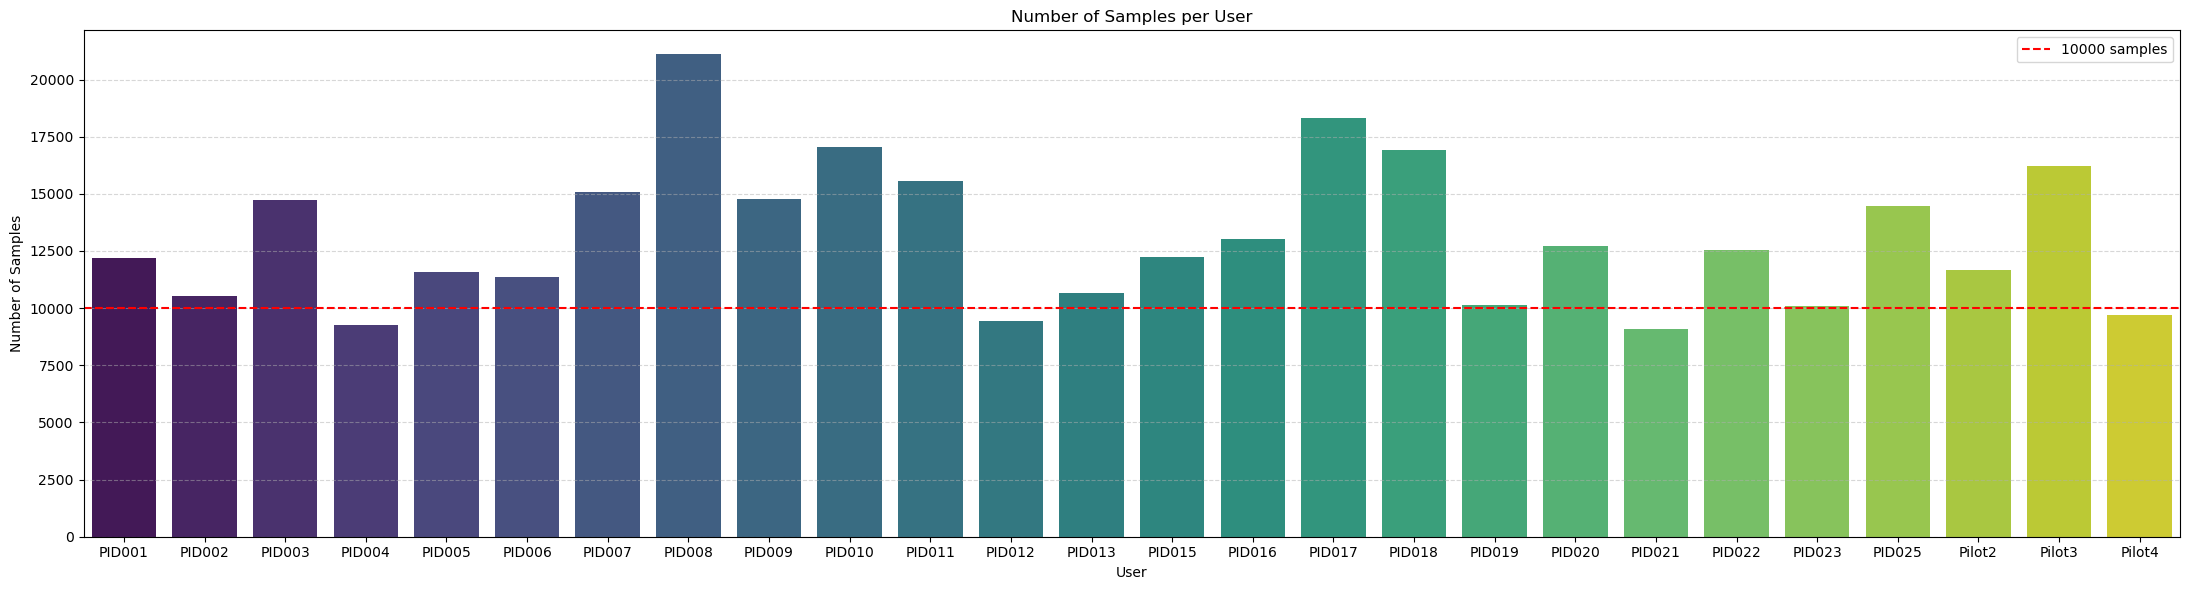

In [112]:
# draw the number of samples for each scenario

df = df[df['F1_max']<10]
num_samples = df.groupby(by='User').size().reset_index(name='Num Samples')
plt.figure(figsize=(22, 6))
sns.barplot(x='User', y='Num Samples', data=num_samples, palette='viridis')
plt.title('Number of Samples per User')
plt.xlabel('User')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# add 10000 reference line
plt.axhline(y=10000, color='r', linestyle='--', label='10000 samples')
plt.legend()

plt.tight_layout()
plt.savefig("../data/Plots/num_samples_per_user.png")
plt.show()

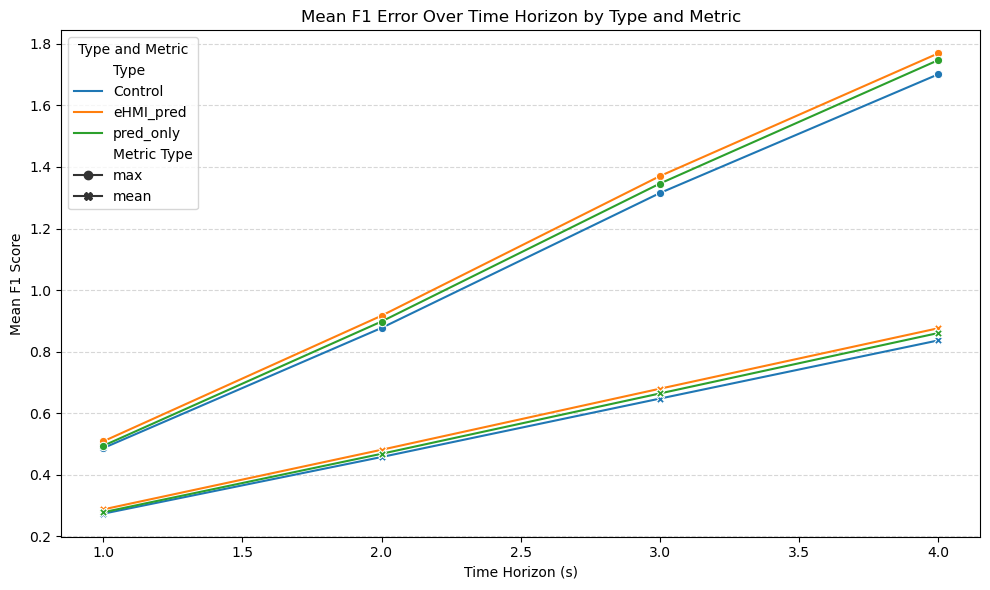

In [96]:
# Assuming df is your DataFrame
melted_df = df.melt(id_vars=['Type'], 
                     value_vars=['F1_max_1s', 'F1_mean_1s', 
                                 'F1_max_2s', 'F1_mean_2s', 'F1_max_3s', 'F1_mean_3s', 
                                 'F1_max_4s', 'F1_mean_4s'],
                     var_name="Metric", value_name="F1 Score")

# Extract 'max' or 'mean' and the time horizon
melted_df['Metric Type'] = melted_df['Metric'].apply(lambda x: 'max' if 'max' in x else 'mean')
melted_df['Time Horizon'] = melted_df['Metric'].str.extract(r'(\d+)s').astype(int)

# Aggregate by mean for each Type, Metric Type, and Time Horizon
agg_df = melted_df.groupby(['Type', 'Metric Type', 'Time Horizon'])['F1 Score'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=agg_df, x='Time Horizon', y='F1 Score', hue='Type', style='Metric Type', markers=True, dashes=False)
plt.xlabel("Time Horizon (s)")
plt.ylabel("Mean F1 Score")
plt.title("Mean F1 Error Over Time Horizon by Type and Metric")
plt.legend(title="Type and Metric")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../data/Plots/mean_f1_error_over_time_horizon_by_type_and_metric.png")
plt.show()

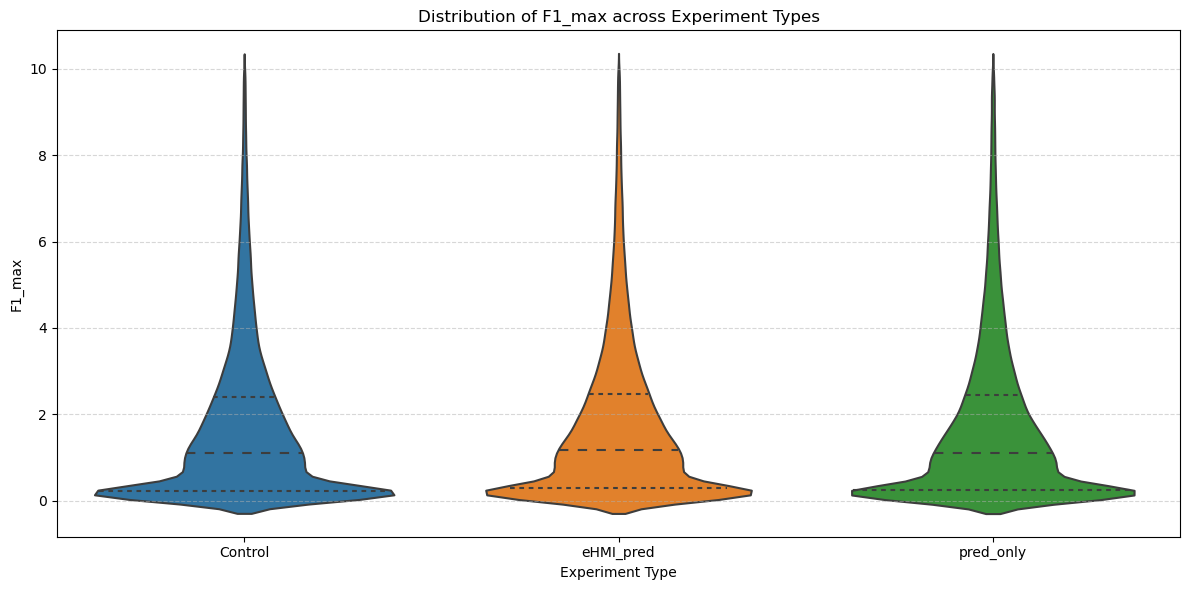

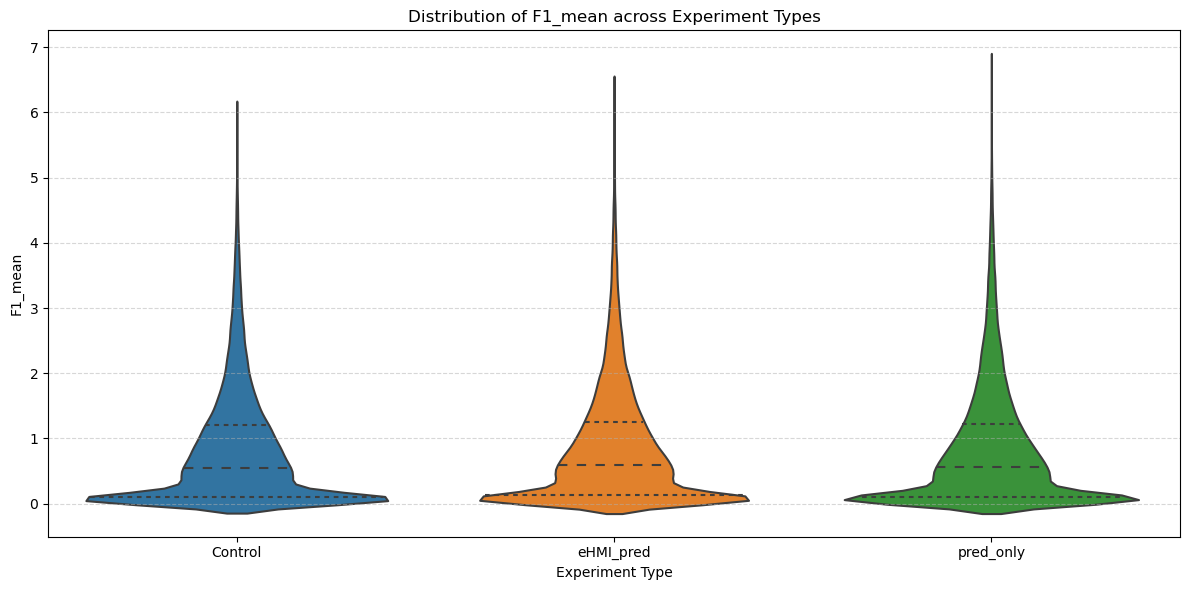

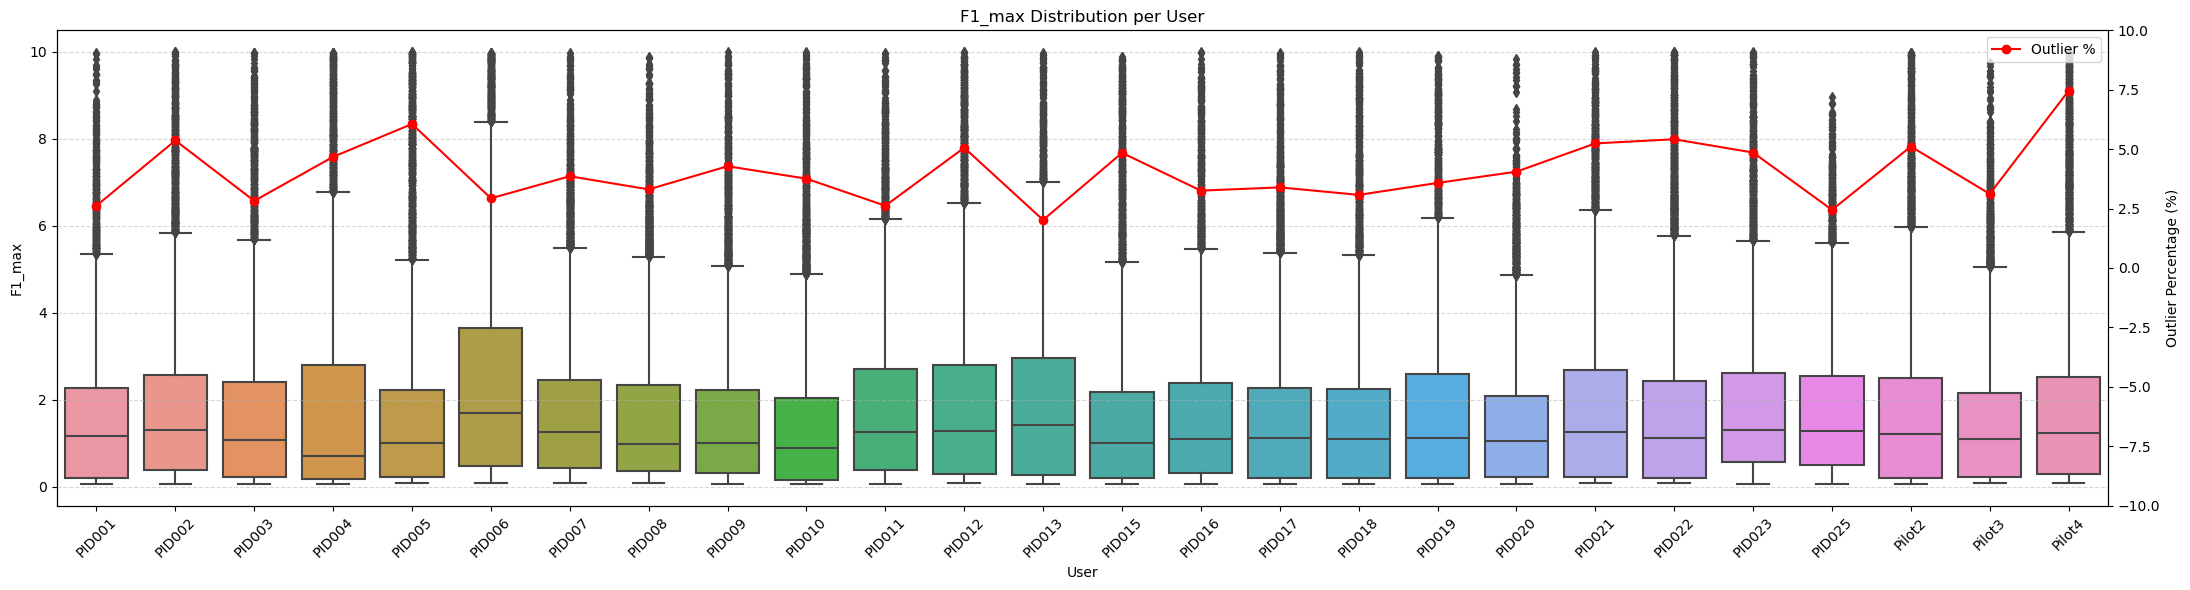

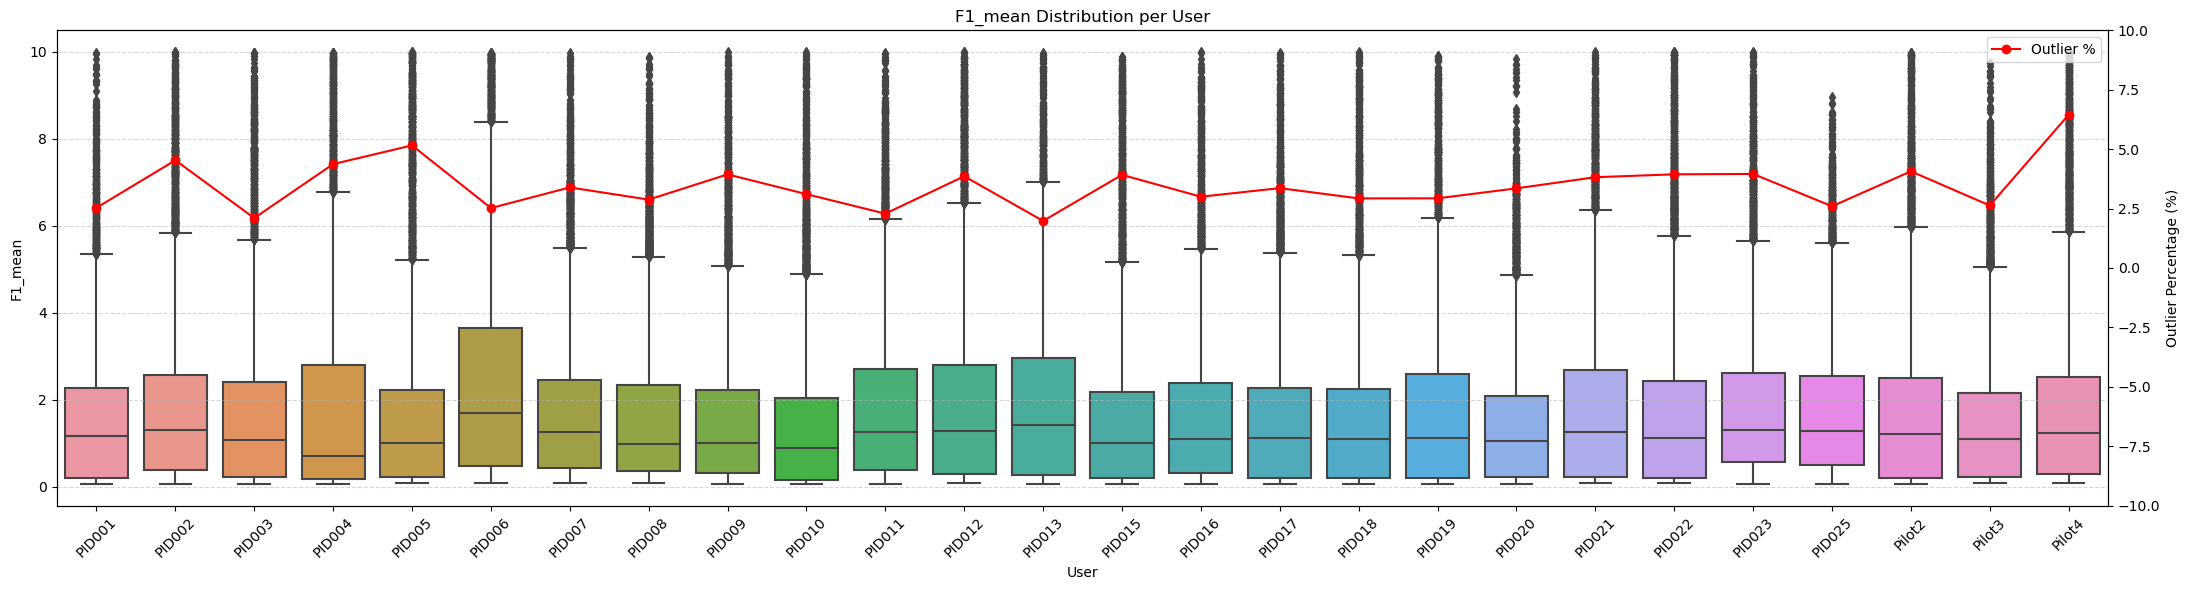

In [122]:
# Violin plot for F1_max and F1_mean across different experiment types
df = df[df['F1_max']<10]

plt.figure(figsize=(12, 6))
sns.violinplot(x='Type', y='F1_max', data=df, inner='quartile')
plt.title('Distribution of F1_max across Experiment Types')
plt.xlabel('Experiment Type')
plt.ylabel('F1_max')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../data/Plots/F1_max_distribution.png")
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(x='Type', y='F1_mean', data=df, inner='quartile')
plt.title('Distribution of F1_mean across Experiment Types')
plt.xlabel('Experiment Type')
plt.ylabel('F1_mean')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../data/Plots/F1_mean_distribution.png")
plt.show()

# Box plot for F1_max and F1_mean per User
# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(22, 6))
# Boxplot for F1_max per User
sns.boxplot(x='User', y='F1_max', data=df, ax=ax1)
ax1.set_title('F1_max Distribution per User')
ax1.set_xlabel('User')
ax1.set_ylabel('F1_max')
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.tick_params(axis='x', rotation=45)
# Compute outlier percentage per user
outlier_counts = df.groupby('User')['F1_max'].apply(
    lambda x: (x > x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))).mean() * 100
) / 1.2
# Create secondary y-axis
ax2 = ax1.twinx()
ax2.plot(outlier_counts.index, outlier_counts.values, color='red', marker='o', linestyle='-', label='Outlier %')
ax2.set_ylabel('Outlier Percentage (%)')
ax2.set_ylim(-10, 10)
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig("../data/Plots/F1_max_distribution_per_user.png")
plt.show()



# Box plot for F1_max and F1_mean per User
# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(22, 6))
# Boxplot for F1_max per User
sns.boxplot(x='User', y='F1_max', data=df, ax=ax1)
ax1.set_title('F1_mean Distribution per User')
ax1.set_xlabel('User')
ax1.set_ylabel('F1_mean')
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.tick_params(axis='x', rotation=45)
# Compute outlier percentage per user
outlier_counts = df.groupby('User')['F1_mean'].apply(
    lambda x: (x > x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))).mean() * 100
) / 1.2
# Create secondary y-axis
ax2 = ax1.twinx()
ax2.plot(outlier_counts.index, outlier_counts.values, color='red', marker='o', linestyle='-', label='Outlier %')
ax2.set_ylabel('Outlier Percentage (%)')
ax2.set_ylim(-10, 10)
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig("../data/Plots/F1_mean_distribution_per_user.png")
plt.show()




## F-1 per scenario

In [102]:
df = df[df['Phase2_scenario_num'] != 1]
df['Phase2_scenario_num'] = df['Phase2_scenario_num'] - 1

In [103]:


# plt.figure(figsize=(22, 6))
# sns.boxplot(x='Phase1_scenario_num', y='F1_mean', data=df)
# plt.title('F1_mean Distribution vs Phase1_scenario_num')
# plt.xlabel('Phase1_scenario_num')
# plt.ylabel('F1_mean')
# # plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.savefig("../data/Plots/F1_mean_distribution_per_phase1.png")
# plt.show()




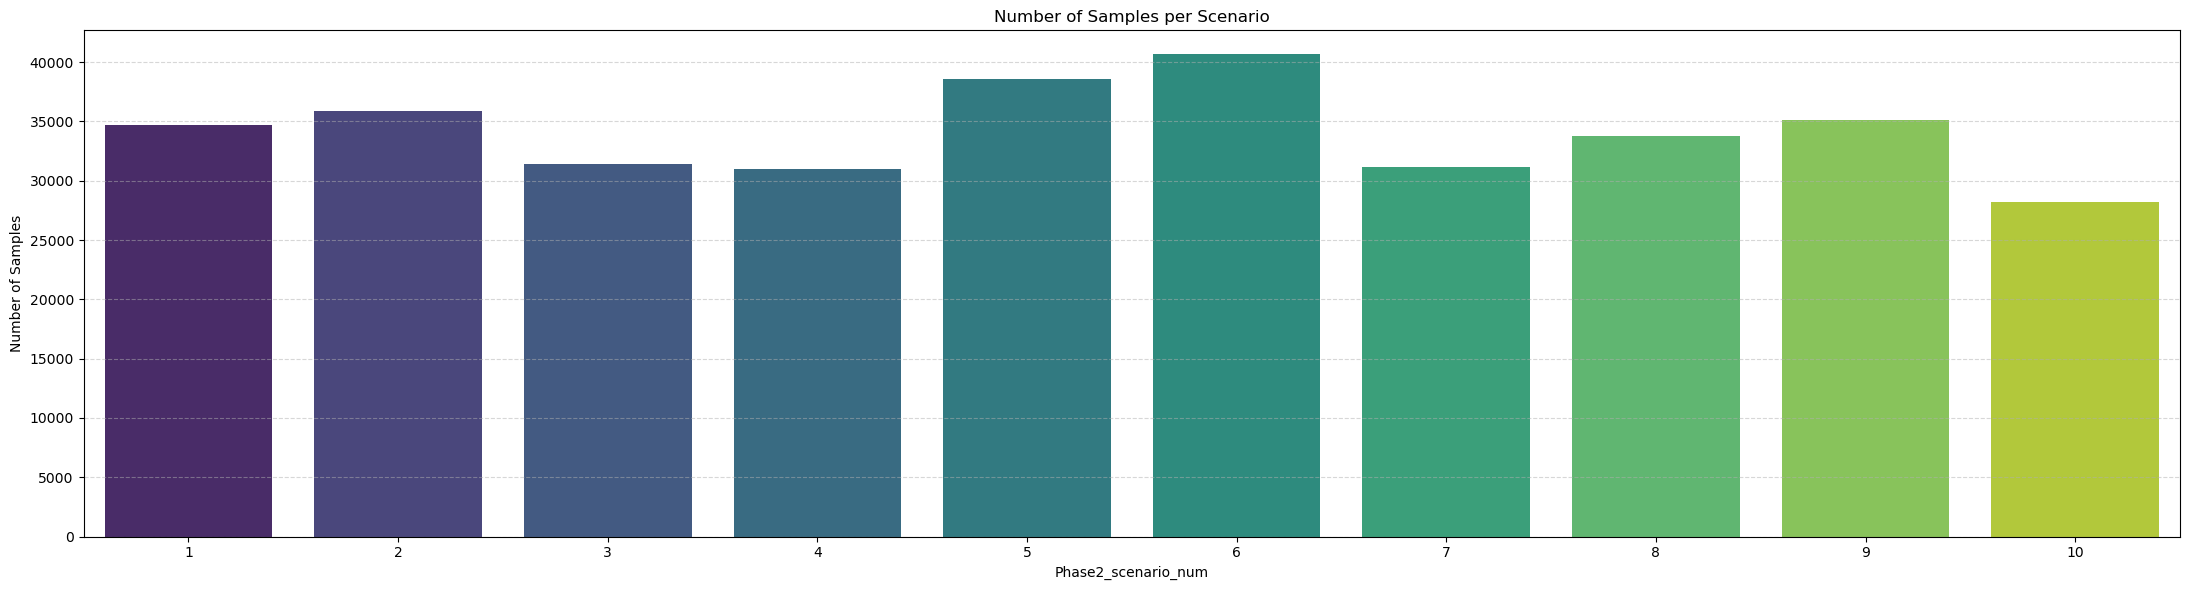

In [108]:
# draw the number of samples for each scenario

df = df[df['F1_max']<10]
num_samples = df.groupby(by='Phase2_scenario_num').size().reset_index(name='Num Samples')
plt.figure(figsize=(22, 6))
sns.barplot(x='Phase2_scenario_num', y='Num Samples', data=num_samples, palette='viridis')
plt.title('Number of Samples per Scenario')
plt.xlabel('Phase2_scenario_num')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../data/Plots/num_samples_per_phase2.png")
plt.show()

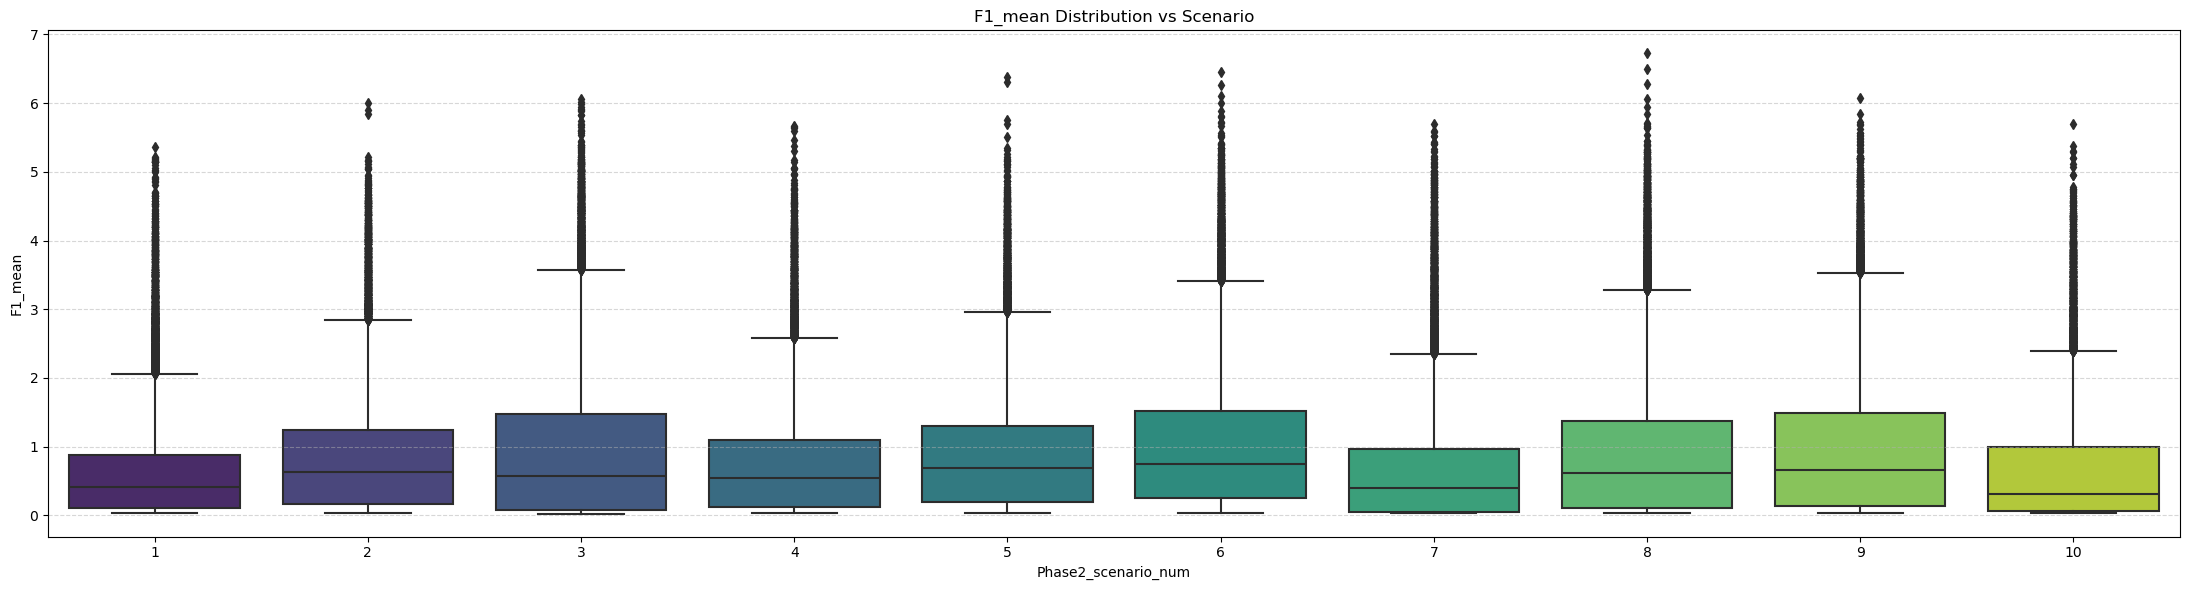

In [109]:
plt.figure(figsize=(22, 6))
sns.boxplot(x='Phase2_scenario_num', y='F1_mean', data=df, palette='viridis')
plt.title('F1_mean Distribution vs Scenario')
plt.xlabel('Phase2_scenario_num')
plt.ylabel('F1_mean')
# plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../data/Plots/F1_mean_distribution_per_phase2.png")
plt.show()